# DESI PV Y1 $z$-bin TFR Calibration w/o zero-pointing

In redshift bins of width 0.001 (or 0.005), identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-bin joint fit to calibrate the TFR at $0.4R_{26}$, weighting the galaxies in the fit by $V(z=0.2)/V_{max}$.  Only use galaxies that pass Alex's criteria cuts:
* $m_r$ < minimum of (17.75, $\mu_{CMB} - 17 + 5\log h$)
* $70 < V(0.4R_{26}) < 300$ km/s
* $V(0.4R_{26}) <$ minimum of (300 km/s, $10^{0.3(\mu_{CMB} - 34 + 5\log h) + 2}$)

Version: **30 October 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 redshift bins, so we need to change the default color map so that they are all plotted with different colors
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, FlatLambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from cosmoprimo.fiducial import DESI

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
sys.path.insert(1, '/global/u1/s/sgmoore1/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')

h = 1.
H0 = 100*h

q0 = 0.2

# Access SGA Jura Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
# sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
sgapath = '../vrot_cats'
# sgafits = os.path.join(sgapath, 'SGA-2020_jura_Vrot.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_jura_Vrot_v0.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,PHOTSYS,V_0p4R26,V_0p4R26_ERR
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,bytes1,float64,float64
20,SGA-2020 20,SDSSJ173412.71+572041.6,3331584,263.5529355,57.34490699999999,S?,152.58,0.4487454,0.5333349,0.08364453,24.92448,18.036,False,LEDA-20181114,5,SDSSJ173412.71+572041.6,1,True,263.5529355,57.34490699999999,0.4487454,2635p572,263.55294849855886,57.344862145664294,0.4460123,SB26,152.3756,0.5778338,263.5528114673963,57.34481025685253,10.459747,5.9780583,5.751067,4.821581,1.4858595,3.4448266,5.1149526,6.748707,8.426254,9.720271,11.022999,12.0887985,13.380368,20.656942,20.044735,19.40886,19.194794,18.66572,18.231262,18.599888,18.123905,17.745926,18.256256,17.807074,17.476473,18.040592,17.60353,17.319197,17.926336,17.500519,17.228865,17.85259,17.42695,17.180876,17.811844,17.39206,17.151228,17.783718,17.36542,17.143204,0.02069058,0.026094317,0.03480586,0.05076174,0.08751116,0.10309491,0.08337893,0.10982923,0.13734566,0.031223593,0.046367057,0.0777883,0.015935475,0.020728666,0.032657374,0.012760426,0.014699919,0.022893604,0.010505663,0.011998588,0.018923525,0.010358521,0.011374098,0.017719442,0.010557283,0.0112259,0.017149422,0.010553381,0.011049819,0.017135512,0.010413324,0.010993488,0.01699026,0.010291049,0.010862263,0.017057167,17.6411,0.6362121,0.53480667,2.8045392,1.7123051,17.22401,0.6144014,0.53440714,2.7180903,2.1161501,17.062769,0.44818503,0.43006793,3.1755726,0.97457016,0,0.08361389105924856,2.6497179035502532e-05,N,136.41609817193677,13.124519097706607
32,SGA-2020 32,PGC

## Compute maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be located to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [4]:
Planck18_h = FlatLambdaCDM(H0=100, Om0=0.3151)

In [5]:
dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

sgatab['DIST_MAX'] = 0.5*sgatab['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

sgatab['MAX_VOL_FRAC'] = sgatab['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

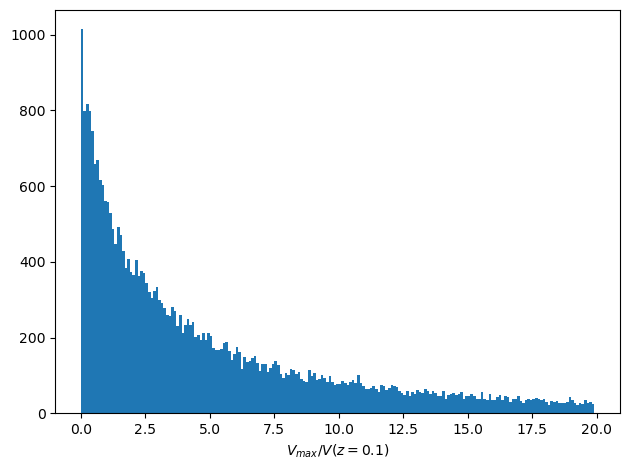

In [6]:
plt.figure(tight_layout=True)

plt.hist(sgatab['MAX_VOL_FRAC'], np.arange(0, 20, 0.1))

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

## Convert to CMB frame

In [7]:
sgatab['Z_DESI_CMB'] = convert_z_frame(sgatab['Z_DESI'], sgatab['RA'], sgatab['DEC'])

## Define dwarfs

We defined dwarfs to have $m_r$ < minimum of (17.75, $\mu_{CMB} - 17 + 5\log h$)

In [8]:
# Using Alex's notation for consistency
Rlim = 17.75
Mlim = -17 + 5*np.log10(h)

sgatab['MU_ZCMB'] = Planck18_h.distmod(sgatab['Z_DESI_CMB'])

Rlim_eff = np.minimum(Rlim, sgatab['MU_ZCMB'] + Mlim)
dwarf_boolean = sgatab['R_MAG_SB26'] > Rlim_eff

# Load Morphological Classification

## SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [10]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
ai_morphpath = '.'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = '/global/homes/s/sgmoore1/DESI_SGA/TF/Y3/SGAY3TFMorphologies.csv'
ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

SGA_ID,Predicted_Type_spiral,Predicted_Type_elliptical,Predicted_Type_irregular,Predicted_Type_lenticular,Predicted_Type
float64,str6,str10,str9,str10,str10
218203.0,Other,Other,Irregular,Other,Irregular
218205.0,Other,Other,Irregular,Other,Irregular
218239.0,Other,Other,Irregular,Other,Irregular
218275.0,Other,Other,Irregular,Other,Irregular
218304.0,Spiral,Other,Other,Other,Spiral
218367.0,Other,Other,Irregular,Other,Irregular
218376.0,Spiral,Other,Other,Other,Spiral
218201.0,Other,Other,Irregular,Other,Irregular
218385.0,Spiral,Other,Other,Other,Spiral


In [12]:
# # Create an overall record of the SSL prediction
# ai_morphtab['Predicted_Type'] = 'Undecided '

# for i in range(len(ai_morphtab)):
    
#     classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
#     ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

### Combine ML morphtypes with SGA catalog

In [11]:
sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

## John Lucey's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We are only considering galaxies that he considers bad for TF (strong asymmetry, double galaxies, stellar contamination).

In [13]:
lucey_VIpath = '../VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

SGA_ID,DESI_NAME,RA,Dec,z_desi,BA,G_R,G_R_err,V_0p4R26,V_0p4R26_err,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,VI
int64,str22,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,str6
692,DESIXJ12411157+1819512,190.298193,18.330884,0.0691,0.5,0.4903,0.0288,92,3,17.0205,0.1382,reject
2526,DESIXJ10124098+4543539,153.170765,45.731651,0.0241,0.3969,0.3677,0.0227,45,2,16.6626,0.1699,reject
2804,DESIXJ07581109+3420293,119.546191,34.341483,0.0198,0.2924,0.5585,0.035,120,0,14.6165,0.1966,reject
3420,DESIXJ01135557+0034028,18.48153,0.567434,0.0418,0.761,0.3742,0.0169,85,11,16.6905,0.0664,reject
5964,DESIXJ16261820+4219580,246.57584,42.332773,0.0465,0.9154,0.3389,0.0122,43,3,16.7172,0.0339,reject
6243,DESIXJ13403564+1214293,205.148492,12.241463,0.0927,0.6161,0.8506,0.0122,345,7,15.5139,0.1067,reject
6493,DESIXJ12450567+1054032,191.273606,10.900881,0.0035,0.8997,0.6761,0.0011,213,12,13.7066,0.0329,reject
6880,DESIXJ16001990+2910066,240.08293,29.168488,0.0772,0.4232,0.6745,0.0258,184,3,15.3161,0.1591,reject
7553,DESIXJ09534429-0005255,148.434553,-0.090407,0.0836,0.7665,0.6715,0.0185,257,9,15.3035,0.0685,reject


### Combine John's results with Y1 TF sample

In [14]:
sgatab = join(sgatab, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
sgatab['VI'].name = 'JOHN_VI'

In [15]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,PHOTSYS,V_0p4R26,V_0p4R26_ERR,D26_kpc,DIST_MAX,MAX_VOL_FRAC,Z_DESI_CMB,MU_ZCMB,MORPHTYPE_AI,JOHN_VI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,mag,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,str10,str6
20.0,SGA-2020 20,SDSSJ173412.71+572041.6,3331584,263.5529355,57.34490699999999,S?,152.58,0.4487454,0.5333349,0.08364453,24.92448,18.036,False,LEDA-20181114,5,SDSSJ173412.71+572041.6,1,True,263.5529355,57.34490699999999,0.4487454,2635p572,263.55294849855886,57.344862145664294,0.4460123,SB26,152.3756,0.5778338,263.5528114673963,57.34481025685253,10.459747,5.9780583,5.751067,4.821581,1.4858595,3.4448266,5.1149526,6.748707,8.426254,9.720271,11.022999,12.0887985,13.380368,20.656942,20.044735,19.40886,19.194794,18.66572,18.231262,18.599888,18.123905,17.745926,18.256256,17.807074,17.476473,18.040592,17.60353,17.319197,17.926336,17.500519,17.228865,17.85259,17.42695,17.180876,17.811844,17.39206,17.151228,17.783718,17.36542,17.143204,0.02069058,0.026094317,0.03480586,0.05076174,0.08751116,0.10309491,0.08337893,0.10982923,0.13734566,0.031223593,0.046367057,0.0777883,0.015935475,0.020728666,0.032657374,0.012760426,0.014699919,0.022893604,0.010505663,0.011998588,0.018923525,0.010358521,0.011374098,0.017719442,0.010557283,0.0112259,0.017149422,0.010553381,0.011049819,0.017135512,0.010413324,0.010993488,0.01699026,0.010291049,0.01086226

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection (both ours and John Lucey's)
* $i > 45^\circ$
* Spiral-type morphology
* Not a dwarf galaxy
* $70~\mathrm{km/s} < V_\mathrm{rot} < 300~\mathrm{km/s}$ at $0.4R_{26}$
* $\log(V_\mathrm{rot}) <$ minimum of log(300 km/s) or $0.3(\mu(z_{CMB}) - 34 - 5\log h) + 2$

The first 1.5 items have already been applied (our VI results have already been applied, but not John's).

In [16]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- John's VI
is_good_John = sgatab['JOHN_VI'].mask

# Alex's velocity cut
Vmin = 70 # km/s
Vmax = 300 # km/s
is_good_vel = (sgatab['V_0p4R26'] > Vmin) & (sgatab['V_0p4R26'] < Vmax)

#- Alex's sliding velocity maximum
logVM_slope = 0.3
logVM_zero = 34 + 5*np.log10(h)
is_good_vel2 = sgatab['V_0p4R26'] < np.minimum(Vmax, 10**(logVM_slope*(sgatab['MU_ZCMB'] - logVM_zero) + 2))

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph_ML & is_good_John & ~dwarf_boolean & is_good_vel & is_good_vel2

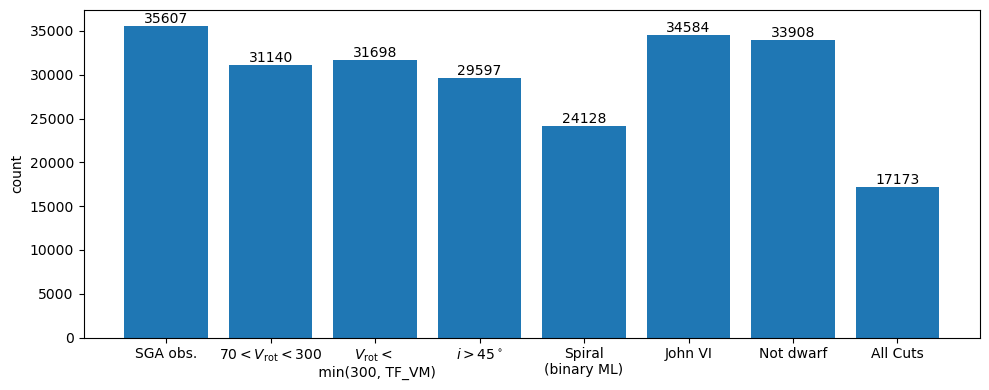

In [17]:
data = {
    'SGA obs.' : len(sgatab),
    r'$70 < V_\mathrm{rot} < 300$' : np.sum(is_good_vel),
    '$V_\mathrm{rot} <$ \n min(300, TF_VM)' : np.sum(is_good_vel2), 
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'John VI' : np.sum(is_good_John), 
    'Not dwarf' : np.sum(~dwarf_boolean), 
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(10,4), tight_layout=True)
bars = ax.bar(names, values, color='tab:blue')
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [18]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### MW dust corrections

In [19]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [20]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/u1/s/sgmoore1/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [21]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [22]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [23]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [24]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [28]:
temp_infile = open('../jura_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [29]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [30]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

## Apply corrections

In [31]:
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [32]:
sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

# Redshift bins

Separate the galaxies into redshift bins of width 0.005, starting at a redshift of 0.03.  (PVs are a significant fraction of the redshift at redshifts less than this.)

In [33]:
zmin = 0.03
zmax = 0.1
dz = 0.005
zbins = np.arange(zmin, zmax, dz)

#- SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

zbin_indices = np.digitize(sgatab_sel['Z_DESI_CMB'], zbins, right=True)

In [34]:
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')

 0  z <= 0.030  1176 galaxies
 1  0.030 < z <= 0.035  1254 galaxies
 2  0.035 < z <= 0.040  1240 galaxies
 3  0.040 < z <= 0.045  1254 galaxies
 4  0.045 < z <= 0.050  1147 galaxies
 5  0.050 < z <= 0.055  1192 galaxies
 6  0.055 < z <= 0.060  1129 galaxies
 7  0.060 < z <= 0.065  1176 galaxies
 8  0.065 < z <= 0.070  1141 galaxies
 9  0.070 < z <= 0.075  988 galaxies
10  0.075 < z <= 0.080  944 galaxies
11  0.080 < z <= 0.085  945 galaxies
12  0.085 < z <= 0.090  706 galaxies
13  0.090 < z <= 0.095  509 galaxies
14  0.095 < z <= 0.100  387 galaxies
15  z > 0.100  1985 galaxies


In [35]:
_, counts = np.unique(zbin_indices, return_counts=True)

print(np.min(counts[1:-1]), np.max(counts[1:-1]))

387 1254


# Build the Calibration Table of SGA Galaxies

In [36]:
sgatab_sel['Z_BIN_IDX'] = zbin_indices

no_use = (zbin_indices == 0) | (zbin_indices == len(zbins))
caltab = sgatab_sel[~no_use]

rejtab = sgatab_sel[no_use]

# caltab.write('SGA-2020_jura_Vrot_zbin_calib_z0p1_Anthony2_dVsys.fits', overwrite=True)
caltab[['Z_BIN_IDX', 'Z_DESI_CMB', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_ERR']]

Z_BIN_IDX,Z_DESI_CMB,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_ERR
int64,float64,float64,float64,float64,float64,float64
14,0.09584227550618851,32.0,15.39881034989059,0.13444716677856366,241.38910738701114,16.455981009957803
11,0.08162259792451398,38.0,16.78364852003902,0.1357104353452215,121.85181571803045,11.00570442529723
14,0.09910676616970915,53.0,16.275697542579472,0.0953915024876824,245.09271422144894,13.42596520278498
4,0.0450825224094471,55.0,16.933866379400715,0.11025944828069938,82.26919023451443,6.5545942979132175
4,0.04576246551386931,63.0,16.17437105551362,0.16591612356457702,89.06956394657158,5.5229133758291855
2,0.039043619899402415,74.0,15.792903292775154,0.20340023235506446,92.4448193399801,10.180695235380485
6,0.05562909723504572,76.0,16.028698452543466,0.11226219399904183,131.6844974517051,12.218627917706675
13,0.09120672548251285,117.0,16.011740269241855,0.14077943692258976,182.85282148131466,12.978851655965396
3,0.044272217700709104,149.0,15.602107292792386,0.0846540122496297,166.0794964665077,13.105132531578198


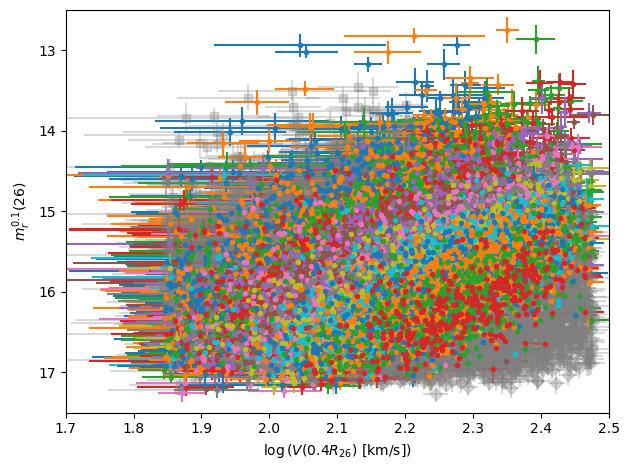

In [37]:
# fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)
fig, axes = plt.subplots(1, 1, tight_layout=True)

logV0 = 0

# ax = axes[0] 
ax = axes

#-------------------------------------------------------------------------------
# Plot galaxies with failed cluster selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(rejtab['Z_BIN_IDX'])
markers = 'sDv^<>'
for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(rejtab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_ERR'][select_zbin].data / rejtab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_zbin].data

    if _zbin_id == 0:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z $\leq$ {zbins[_zbin_id]:.3f} (rej.)')
    else:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z > {zbins[_zbin_id-1]:.3f} (rej.)')
#-------------------------------------------------------------------------------
# Plot galaxies and clusters passing all selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,len(_zbin_ids)+1)))

for _zbin_id in _zbin_ids:
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_ERR'][select_zbin].data / caltab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_zbin].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', 
                label=f'{zbins[_zbin_id-1]:.3f}-{zbins[_zbin_id]:.3f}')
#-------------------------------------------------------------------------------

ax.set(xlim=[1.7, 2.5],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[17.5, 12.5],
       ylabel=r'$m_r^{0.1} (26)$');

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [38]:
#- Extract redshift bins
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])
m = len(_zbin_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

logV0 = np.median(np.log10(caltab['V_0p4R26']))
print('logV0 =', logV0)

#- Loop over the redshift bins
for k, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_zbin]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_zbin] / caltab['V_0p4R26'][select_zbin])
    mag.append(caltab['R_MAG_SB26_CORR'][select_zbin])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_zbin])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_zbin]))

logV0 = 2.1846524297840224


## Multiline Fit using HyperFit

In [52]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += m*[(-20, 20)]                # Bounds on b (intercepts: z-bins)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, weights=weights, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -10680393.83553645
     jac: array([-30.1748516 ,   1.490116  ,  40.41939639, -31.10617142,
       -10.24454747, -16.01874696,  10.80334097, -12.10719247,
       -15.08742446,  48.80129887, -55.69308535, -45.63480238,
       -20.30283045,  11.92092797,   1.6763805 ,  14.71489669])
 message: 'Optimization terminated successfully.'
    nfev: 43678
     nit: 180
 success: True
       x: array([-7.30071736, 14.43734376, 14.75000911, 14.99632043, 15.22832235,
       15.44812842, 15.6232745 , 15.82995009, 16.00184222, 16.16282469,
       16.30828537, 16.4611806 , 16.59309704, 16.7695148 , 16.92288364,
        0.43698038])
Ndim: 16 14


100%|██████████| 1000/1000 [00:53<00:00, 18.56it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [102.93973007  28.96908318  22.65425603  27.0385577   28.83933247
  47.59542238  36.59202901  39.56929207  38.71300394  38.99344291
  77.707831    91.71868861  81.46550148  53.94285921  67.89944575
  63.31306844] / 5146.986503392577


100%|██████████| 1000/1000 [00:54<00:00, 18.39it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [88.1492244  33.21698085 23.07587402 25.3302075  31.29187508 45.26059828
 40.69827055 41.58224219 40.1240979  65.7806009  58.23838244 53.8293802
 72.8250618  86.49971505 70.8545092  77.34613005] / 4407.46122023577


100%|██████████| 1000/1000 [00:54<00:00, 18.23it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [124.5439306   32.13974759  28.54439417  22.99636173  28.9277447
  45.36138119  34.84734816  41.23048557  35.25721069  60.5623799
  66.68579885  57.7793048   77.37297657  94.75313954  97.22053042
  95.58650347] / 6227.196529934969


100%|██████████| 1000/1000 [00:58<00:00, 17.21it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 91.32689891  29.30912106  29.68986596  25.70687461  37.518452
  26.94452664  38.99124594  67.49908218  43.43904483  58.7474937
  82.36013314  60.5171954  105.13200602  98.40140647 113.02398165
 114.06735246] / 5703.3676230498895


100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 87.65982111  29.9794116   25.14617749  26.54513012  37.23958248
  34.24540936  35.21250717  57.9876132   55.48812391  78.26708923
  83.95836106  60.98498865  88.06869647  91.71282324 118.95994527
 114.48089863] / 5947.997263386971


100%|██████████| 1000/1000 [00:55<00:00, 18.03it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [155.46132955  30.09478877  25.614555    29.22091052  37.98576639
  39.36547006  35.68959333  59.83004601  56.97151327  52.99877882
  92.57624412  67.73958924  79.50123572  91.87177342 120.09199279
 115.77998115] / 7773.066477316783


100%|██████████| 1000/1000 [00:56<00:00, 17.67it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [160.43847761  29.17130186  26.42433116  27.15421547  42.09223704
  37.37106521  35.96303028  63.53757104  73.68221597  55.45823312
 104.18189869  91.74882678  84.16326917 186.6087891  132.07726535
 127.31074108] / 9330.43945509131


100%|██████████| 1000/1000 [00:56<00:00, 17.71it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [161.95403256  29.46761843  23.21751092  27.38251525  36.86436335
  38.5931906   39.26851443  55.56022352  72.78114525  53.49384901
  60.81540909  96.56191002  82.18469693 163.98736348 115.76278918
 124.78010895] / 8199.368173982133


100%|██████████| 1000/1000 [00:55<00:00, 18.05it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [140.50982802  29.69231163  24.10564103  27.47447198  35.38061906
  38.1721342   40.56652219  56.75605069  66.84843764  61.71790689
  56.6745869   87.35921429  92.24040528 142.54280005 122.88705455
 116.5892055 ] / 7127.140002328937


100%|██████████| 1000/1000 [00:54<00:00, 18.45it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [128.04076214  30.37659582  23.57111311  28.95371436  37.04062332
  38.59480453  42.41235087  53.78156706  51.20535538  61.32146029
  51.75734369  85.48805467  99.31670844 150.01678364 119.8792826
 120.36218988] / 7500.839182148601


100%|██████████| 1000/1000 [00:55<00:00, 17.89it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [129.14945452  29.69635265  22.73662817  28.18950875  35.58784282
  38.03620023  41.5041188   54.38401978  49.29677449  62.22773151
  55.86570545  82.56462991 106.76165509 145.36045036 122.59002254
 121.44411512] / 7268.022518123068


100%|██████████| 1000/1000 [00:54<00:00, 18.34it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [134.2715393   29.52046155  22.82409766  26.74499641  35.91282039
  36.43496399  41.77808333  52.32944063  53.05028788  66.90376317
  57.50647066  86.33066561 101.94927773 149.85341014 117.61952249
 126.05147309] / 7492.670507035332


100%|██████████| 1000/1000 [00:54<00:00, 18.24it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [133.22546344  28.94412509  22.32877633  28.74452885  35.05948472
  36.38891732  40.64836159  53.75686126  52.19801477  66.43524858
  54.97489737  85.7232952  106.58038524 153.6893445  115.28618801
 127.57172016] / 7684.467224967185


100%|██████████| 1000/1000 [00:53<00:00, 18.84it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [167.14638308  31.03976085  22.32147442  29.14589392  30.74915805
  34.30697112  39.97162972  48.17452408  40.70310234  68.20310875
  63.27802984  64.81235784  84.73553728 118.46044691 119.93528986
 129.71356737] / 8357.319154039706


100%|██████████| 1000/1000 [00:52<00:00, 18.89it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [143.78449488  30.19140723  22.68385409  28.87413008  30.63587172
  33.63394954  39.72715462  47.24706851  39.07457623  66.22078346
  61.8006883   63.66838337  89.8949105  112.8333511  120.57204499
 133.51400596] / 7189.224743794858


100%|██████████| 1000/1000 [00:53<00:00, 18.63it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [136.56568821  31.00374109  25.75099138  27.75867783  30.69828042
  36.22530332  38.73939116  49.19845065  40.06725425  66.78974016
  71.77783062  69.16650745  90.9712428  109.11170177 119.90831369
 133.78329949] / 6828.284410454322


100%|██████████| 1000/1000 [00:54<00:00, 18.33it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [142.74624831  32.81511465  25.75572971  27.38742942  30.54868107
  38.38833861  36.72003986  49.06498918  38.85682777  65.81804742
  70.68378707  66.75484612  88.10880816 108.79573165 118.16350756
 137.74501848] / 7137.312415675454


100%|██████████| 1000/1000 [00:55<00:00, 17.93it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [135.89103365  32.40488519  25.74141826  27.13506179  31.84537868
  38.36583446  37.59217008  48.16127806  40.8635103   62.05835962
  74.54627894  69.56297689  87.90155522 117.50563063 116.001416
 158.48272627] / 7924.136313683392


100%|██████████| 1000/1000 [00:55<00:00, 18.17it/s]


Niterations/Max Iterations:  19000 / 100000
Integrated ACT/Min Convergence Iterations:  [133.78579305  32.34338565  25.52151326  26.73653533  31.26300261
  38.1379106   37.76298341  48.35009533  40.72970911  60.17946251
  73.44835222  69.37521     86.26145722 116.02367641 115.24592571
 156.64266723] / 7832.133361741643


In [53]:
temp_outfile = open('/pscratch/sd/s/sgmoore1/TF/pickles/cov_ab_jura_jointTFR_v0.pickle', 
                    'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0, zmin, zmax, dz, zbins), temp_outfile)
temp_outfile.close()

In [44]:
# temp_infile = open('cov_ab_jura_jointTFR_v14.pickle', 'rb')
# cov_tfr, tfr_mcmc_samples, logV0, zmin, zmax, dz, zbins = pickle.load(temp_infile)
# temp_infile.close()

In [44]:
values = np.median(tfr_mcmc_samples, axis=1)
sigmas = np.sqrt(np.diag(cov_tfr))

multiple = 3.5

limits = []

for i in range(len(values)):
    limits.append([values[i] - multiple*sigmas[i], 
                   values[i] + multiple*sigmas[i]])

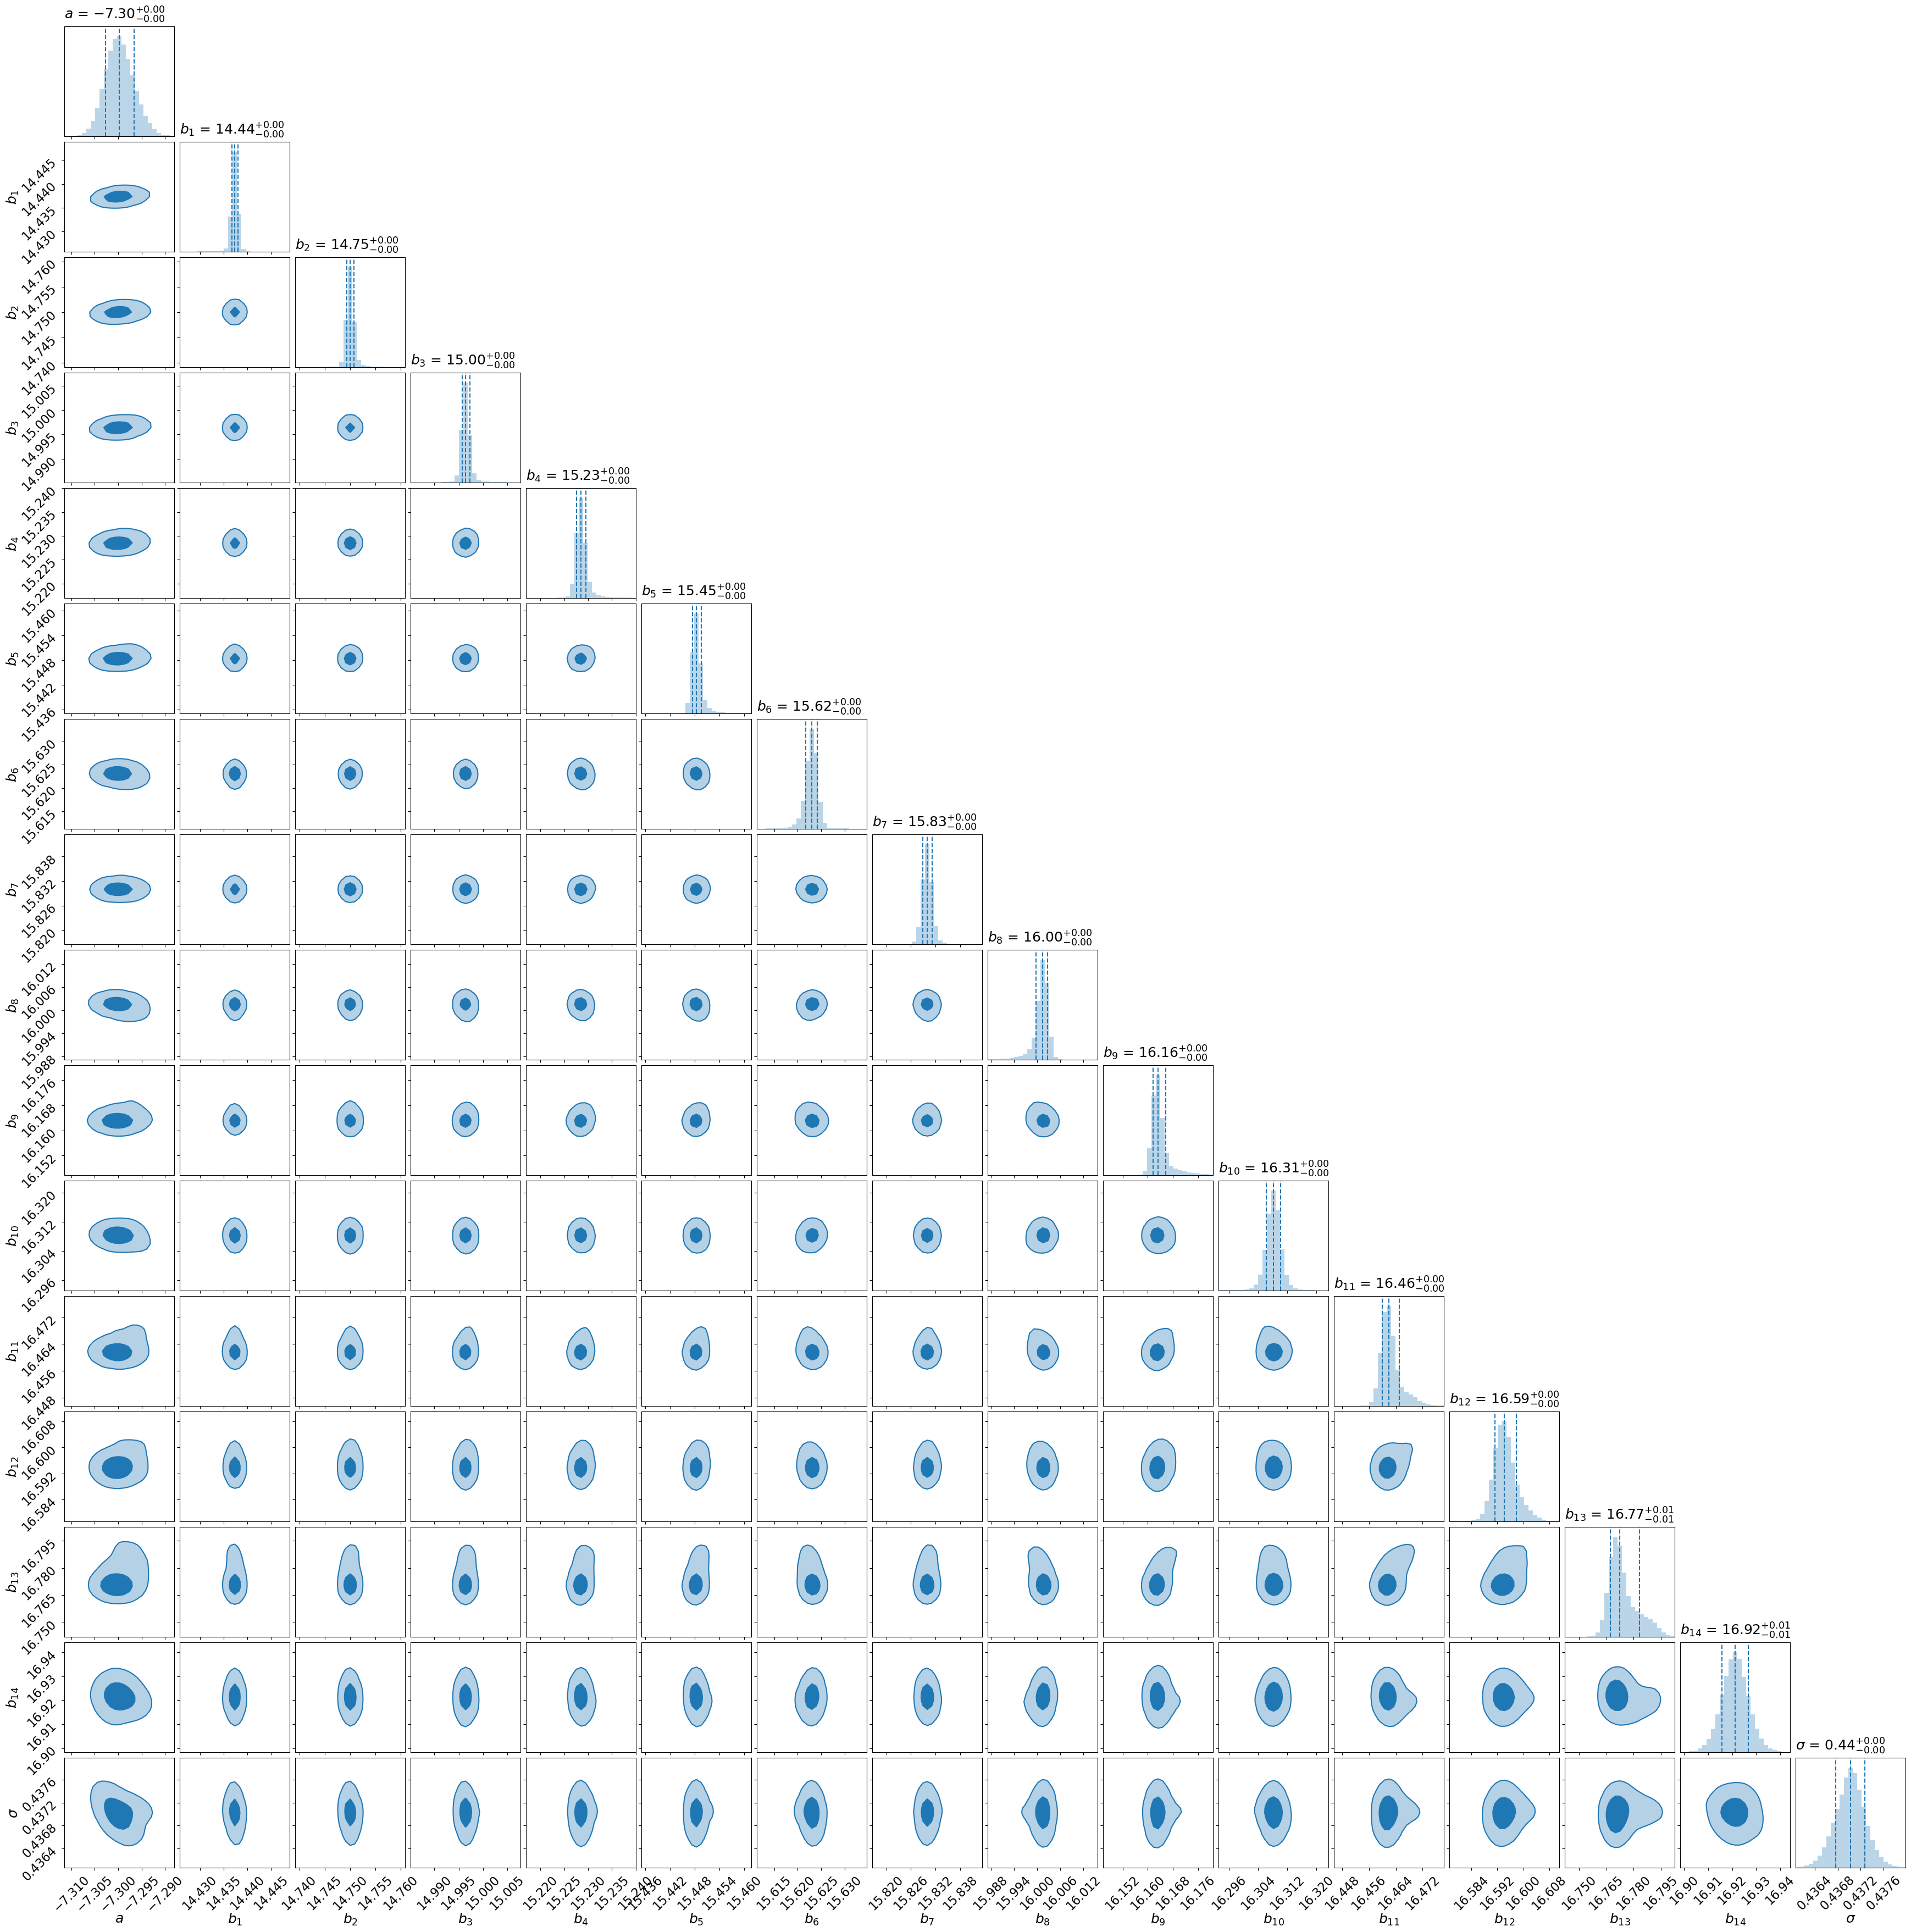

In [45]:
labels  = ['$a$']
labels += [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$']

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
             range=limits,
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

### Plot the HyperFit Results

In [46]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+1):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

In [47]:
print(sigma_mcmc[1], '+', sigma_mcmc[2]-sigma_mcmc[1], ', -', sigma_mcmc[1]-sigma_mcmc[0])

0.43702556959399247 + 0.00024429087450261733 , - 0.00026455270783676266


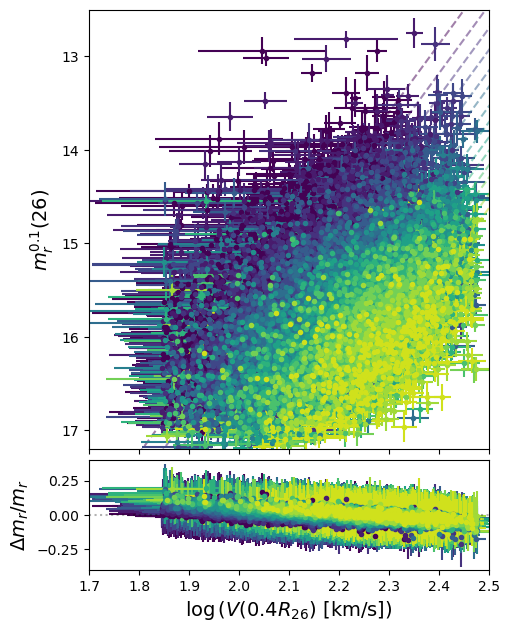

In [48]:
fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b_   = b_mcmc[:,1]

#- Plot redshift bins
ax = axes[0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV0 + logV[k],
                     y=mag[k],
                     xerr=logV_err[k],
                     yerr=mag_err[k],
                     fmt='.', 
                     label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

ax.set(xlim=[1.7, 2.5],
       ylim=[17.2, 12.5])
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot residuals: z-bins
ax = axes[1]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

for k in range(m):
    logv_obs = logV[k]
    m_obs = mag[k]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                     xerr=logV_err[k],
                     yerr=mag_err[k],
                     fmt='.')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

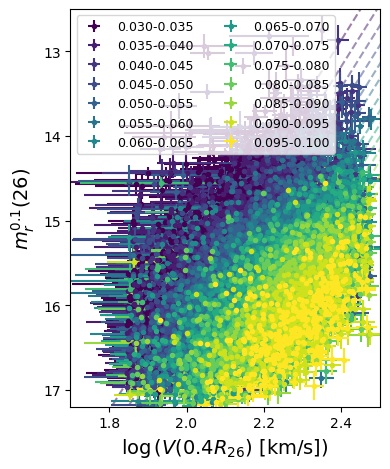

In [49]:
plt.figure(figsize=(4,4.8), tight_layout=True)

a_   = a_mcmc[1]
b_   = b_mcmc[:,1]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = plt.errorbar(x=logV0 + logV[k],
                      y=mag[k],
                      xerr=logV_err[k],
                      yerr=mag_err[k],
                      fmt='.', 
                      label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

plt.xlim([1.7, 2.5])
plt.ylim([17.2, 12.5])
plt.ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
plt.xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14);

plt.legend(loc='upper left', fontsize=9, ncol=2);

# plt.savefig('../../../figures/Y1_papers/TF_Y1_zbin_calibration_dz0p005_Anthony2_weightsVmax-1_20250810.png', 
#             dpi=150, 
#             facecolor='none')

In [50]:
print(f'slope (alpha): {-a_/2.5:.3f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.920 +/- 0.001


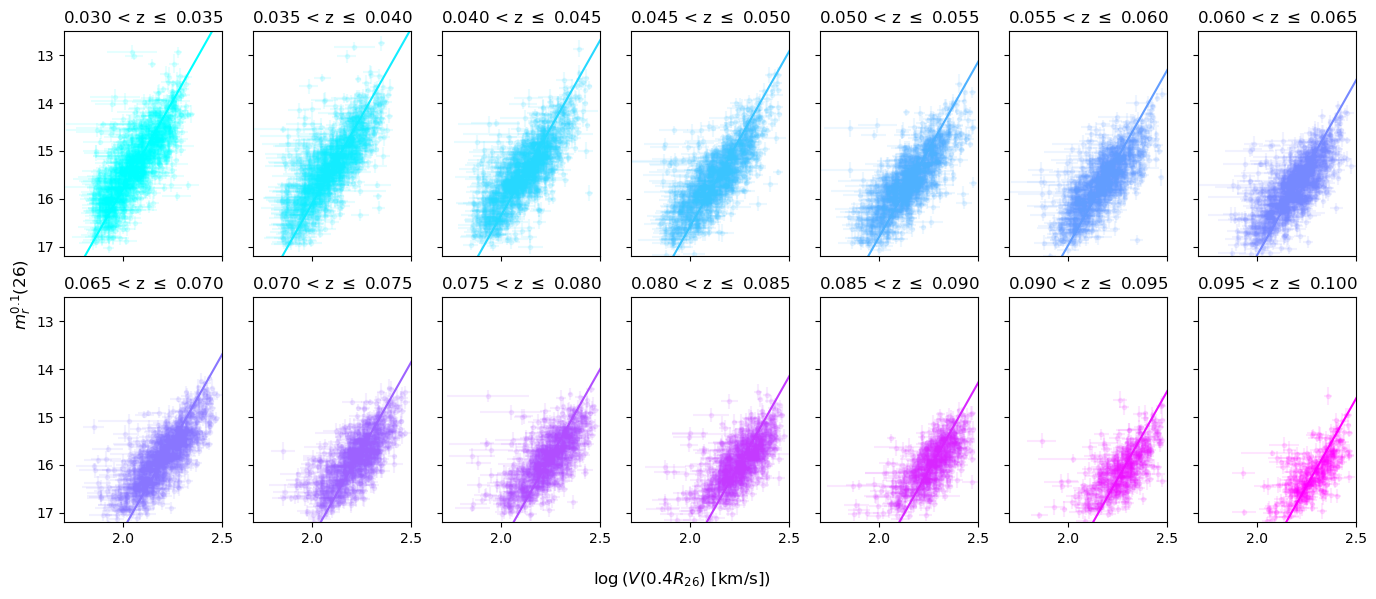

In [51]:
# fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
fig, axs = plt.subplots(nrows=2, ncols=7, sharex=True, sharey=True, figsize=(14,6), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/7)
    col = i%7
    
    eb = axs[row,col].errorbar(logV0 + logV[i],
                               mag[i],
                               xerr=logV_err[i],
                               yerr=mag_err[i],
                               fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.7, 2.5], ylim=[17.2, 12.5], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')